In [2]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Function to load and preprocess data
def preprocess_stock_data(csv_file_path):
    # Step 1: Load dataset
    df = pd.read_csv(csv_file_path)
    df.drop(columns=['Unnamed: 0'], inplace=True) #optional
    # Convert 'Date' column to datetime format
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

    # Feature extraction from 'Date' column
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['Day_of_Week'] = df['Date'].dt.dayofweek
    df['Is_Weekend'] = df['Day_of_Week'].isin([5, 6]).astype(int)  # 5 = Saturday, 6 = Sunday
    df['Quarter'] = df['Date'].dt.quarter
    df['Is_Month_Start'] = df['Date'].dt.is_month_start.astype(int)
    df['Is_Month_End'] = df['Date'].dt.is_month_end.astype(int)
    
    
    
    # Step 2: Handle missing values
    imputer = SimpleImputer(strategy='median')
    col_miss = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    df[col_miss] = imputer.fit_transform(df[col_miss])

    # Step 3: Detect and remove outliers
    def detect_remove_outliers(df, cols):
        iso = IsolationForest(contamination=0.05, random_state=42)
        for col in cols:
            df['Outlier'] = iso.fit_predict(df[[col]])
            df = df[df['Outlier'] != -1]
        df.drop(columns=['Outlier'], inplace=True)
        return df

    cols_to_check = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    df_cleaned = detect_remove_outliers(df, cols_to_check)

    # Step 4: Target Encoding for 'Symbol' column
    encoder = ce.TargetEncoder(cols=['Symbol'])
    target_col = 'Close'
    df_cleaned['Symbol'] = encoder.fit_transform(df_cleaned['Symbol'], df_cleaned[target_col])

    # Step 5: Add technical indicators
    df_cleaned['SMA_10'] = df_cleaned['Adj Close'].rolling(window=10).mean()
    df_cleaned['SMA_50'] = df_cleaned['Adj Close'].rolling(window=50).mean()
    df_cleaned['EMA_10'] = df_cleaned['Adj Close'].ewm(span=10, adjust=False).mean()
    df_cleaned['EMA_50'] = df_cleaned['Adj Close'].ewm(span=50, adjust=False).mean()
    df_cleaned['SMA_20'] = df_cleaned['Adj Close'].rolling(window=20).mean()
    df_cleaned['STD_20'] = df_cleaned['Adj Close'].rolling(window=20).std()
    df_cleaned['Upper_Band'] = df_cleaned['SMA_20'] + (df_cleaned['STD_20'] * 2)
    df_cleaned['Lower_Band'] = df_cleaned['SMA_20'] - (df_cleaned['STD_20'] * 2)
    df_cleaned['High-Low'] = df_cleaned['High'] - df_cleaned['Low']
    df_cleaned['High-Close'] = np.abs(df_cleaned['High'] - df_cleaned['Adj Close'].shift(1))
    df_cleaned['Low-Close'] = np.abs(df_cleaned['Low'] - df_cleaned['Adj Close'].shift(1))
    df_cleaned['True_Range'] = df_cleaned[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)
    df_cleaned['ATR'] = df_cleaned['True_Range'].rolling(window=14).mean()
    delta = df_cleaned['Adj Close'].diff(1)
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=14).mean()
    avg_loss = pd.Series(loss).rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df_cleaned['RSI'] = 100 - (100 / (1 + rs))
    df_cleaned['EMA_12'] = df_cleaned['Adj Close'].ewm(span=12, adjust=False).mean()
    df_cleaned['EMA_26'] = df_cleaned['Adj Close'].ewm(span=26, adjust=False).mean()
    df_cleaned['MACD'] = df_cleaned['EMA_12'] - df_cleaned['EMA_26']
    df_cleaned['Signal_Line'] = df_cleaned['MACD'].ewm(span=9, adjust=False).mean()
    df_cleaned['VWAP'] = (df_cleaned['Close'] * df_cleaned['Volume']).cumsum() / df_cleaned['Volume'].cumsum()
    df_cleaned['Adj Close_Lag1'] = df_cleaned['Adj Close'].shift(1)
    df_cleaned['Adj Close_Lag2'] = df_cleaned['Adj Close'].shift(2)
    df_cleaned['Adj Close_Lag3'] = df_cleaned['Adj Close'].shift(3)

    # Step 6: Fill NaN values with bfill and ffill
    df_cleaned.fillna(method='bfill', inplace=True)
    df_cleaned.fillna(method='ffill', inplace=True)

    # Step 7: Normalization and Standardization
    numeric_columns = [
        'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Symbol', 
        'SMA_10', 'SMA_50', 'EMA_10', 'EMA_50', 'SMA_20', 'STD_20', 
        'Upper_Band', 'Lower_Band', 'High-Low', 'High-Close', 'Low-Close', 
        'True_Range', 'ATR', 'RSI', 'EMA_12', 'EMA_26', 'MACD', 
        'Signal_Line', 'VWAP', 'Adj Close_Lag1', 'Adj Close_Lag2', 'Adj Close_Lag3'
    ]

    # Normalization
    scaler_minmax = MinMaxScaler()
    df_normalized = df_cleaned.copy()
    df_normalized[numeric_columns] = scaler_minmax.fit_transform(df_cleaned[numeric_columns])

    # Standardization
    scaler_standard = StandardScaler()
    df_standardized = df_cleaned.copy()
    df_standardized[numeric_columns] = scaler_standard.fit_transform(df_cleaned[numeric_columns])

    # Return the cleaned, normalized, and standardized datasets
    return df_cleaned, df_normalized, df_standardized

# Call the function with your CSV file path
df_cleaned, df_normalized, df_standardized = preprocess_stock_data("stocks_sample.csv")


C:\Users\sahoo\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\sahoo\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Windows\Temp\ipykernel_1308\2192993909.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Outlier'] = iso.fit_predict(df[[col]])
C:\Users\sahoo\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\sahoo\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning

In [3]:
df_normalized = df_normalized.drop(['Date'],axis=1)

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


In [5]:
# Select features and target
features = df_normalized.drop(['High'], axis=1)  # Drop 'High' for features
target = df_normalized['High']  # Set 'High' as the target


In [6]:
# Split the dataset
train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.2, shuffle=False)


In [7]:
# Reshape the features for LSTM [samples, time steps, features]
train_features = np.array(train_features).reshape((train_features.shape[0], 1, train_features.shape[1]))
test_features = np.array(test_features).reshape((test_features.shape[0], 1, test_features.shape[1]))


In [8]:
# Initialize the model
model = Sequential()

# Add LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
model.add(Dropout(0.2))

# Add another LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Add a dense layer
model.add(Dense(units=25))
model.add(Dense(units=1))  # Output layer for predicting a single value

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


C:\Users\sahoo\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# Train the model
history = model.fit(train_features, train_target, epochs=20, batch_size=32, validation_data=(test_features, test_target))


Epoch 1/20
1697/1697 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0289 - val_loss: 0.0267
Epoch 2/20
1697/1697 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0282 - val_loss: 0.0269
Epoch 3/20
1697/1697 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0279 - val_loss: 0.0267
Epoch 4/20
1697/1697 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0283 - val_loss: 0.0267
Epoch 5/20
1697/1697 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0279 - val_loss: 0.0268
Epoch 6/20
1697/1697 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0281 - val_loss: 0.0269
Epoch 7/20
1697/1697 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0279 - val_loss: 0.0271
Epoch 8/20
1697/1697 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0281 - val_loss: 0.0267
Epoch 9/20
1697/1697 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0283 - val_loss: 0.0268
Epoch 10/20
1697/1697 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0279 - val_loss: 0.0268
Epoch 11/20
1697/1697 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0279 - val_loss: 0.0267
Epoch 12/20
1697/1697 ━━━━

In [10]:
# Predict on test data
predictions = model.predict(test_features)

# Convert predictions and actual values back to the original scale if needed
predictions = predictions.flatten()  # Flatten for easier handling

# Check results
print("Predictions:", predictions[:10])  # Show the first 10 predictions
print("Actual High Values:", test_target[:10].values)  # Show the first 10 actual values


425/425 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Predictions: [0.19042797 0.19042797 0.19042797 0.19042797 0.19042797 0.19042797
 0.19042797 0.19042797 0.19042797 0.19042797]
Actual High Values: [0.11190912 0.10951507 0.10885289 0.10691727 0.11027913 0.10452322
 0.10538916 0.11272411 0.11252037 0.11170537]


Mean Absolute Error (MAE): 0.14054900733116243
Mean Squared Error (MSE): 0.026999162745457397
Root Mean Squared Error (RMSE): 0.1643142195473581


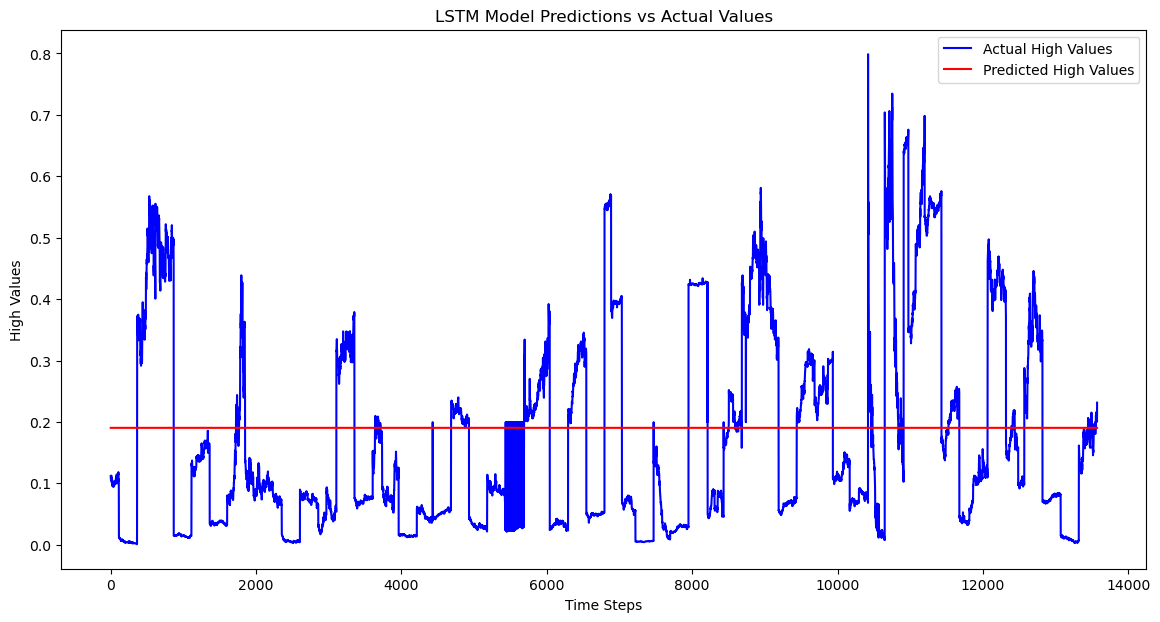

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Calculate performance metrics
mae = mean_absolute_error(test_target, predictions)
mse = mean_squared_error(test_target, predictions)
rmse = np.sqrt(mse)

# Print performance metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Plotting predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(test_target.values, label='Actual High Values', color='blue')
plt.plot(predictions, label='Predicted High Values', color='red')
plt.title('LSTM Model Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('High Values')
plt.legend()
plt.show()


In [13]:
from tensorflow.keras.models import load_model

# Save the model as an HDF5 file
model.save("lstm_model.h5")


In [18]:
import joblib

# Save using joblib (for sklearn-type models)
joblib.dump(model, "lstm_model.pkl")


['lstm_model.pkl']

In [19]:
# Save the model to Downloads
model.save("C:/Users/sahoo/Downloads/lstm_model.h5")

# OR, for joblib format
joblib.dump(model, "C:/Users/sahoo/Downloads/lstm_model.pkl")


['C:/Users/sahoo/Downloads/lstm_model.pkl']